# Demo: Siren Evaluation

In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root

root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

# os.environ["JAX_PLATFORM_NAME"] = "CPU"
# # ENSURE JAX DOESNT PREALLOCATE
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(False)

import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.data import make_mini_batcher
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from model import add_model_args, get_model
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics
from viz import add_viz_args, generate_plot_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

2022-06-02 18:16:44.934677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Argumentsget_data_args

In [3]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# model, optimizer, loss
parser = add_model_args(parser)
parser = add_optimizer_args(parser)
parser = add_loss_args(parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)
parser = add_viz_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"
# meom specific
args.log_dir = "/mnt/meom/workdir/johnsonj/logs"

args.smoke_test = False
args.wandb_mode = "online"
args.wandb_resume = True
# ige/nerf4ssh/kx2nr6qb
# ige/nerf4ssh/15uycahn  # radiant pyramid
# ige/nerf4ssh/3zqok2ix  # effortless sky
# ige/nerf4ssh/28eioh2w # dark-matter
args.id = "3zqok2ix" # "mikf2n1v" # "2uuq7tks" "generous-snowflake-46"
# args.entity = "ige"
# args.batch_size = 2048
# args.n_epochs = 10
# args.batch_size = 4096

### Logger


In [4]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (ige). Use `wandb login --relogin` to force relogin
2022-06-02 18:16:51.933099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Load Models (Optional)

In [5]:
!ls $wandb.run.dir

config.yaml  output.log  wandb-summary.json


In [6]:
# if args.server == "jz":
# get id (from this run or a run you can set)
run_id = wandb.run.id

# initialize api
api = wandb.Api()

# get run
run = api.run(f"{args.entity}/{args.project}/{run_id}")

# download the files
files = [
    "scaler.pickle", 
    "model.pickle",
    # "models/model.pickle"
]

for ifile in files:
    
    run.file(ifile).download(replace=True)

In [7]:
model = load_object("./model.pickle")
scaler = load_object("./scaler.pickle")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### PostProcessing

In [8]:
df_grid = generate_eval_data(args)

df_grid.describe()

,longitude,latitude,vtime
count,967980.000000,967980.000000,967980.000000
mean,300.000000,38.100000,213.000000
std,2.943922,3.001668,105.366083
min,295.000000,33.000000,31.000000
25%,297.400000,35.550000,122.000000
50%,300.000000,38.100000,213.000000
75%,302.600000,40.650000,304.000000
max,305.000000,43.200000,395.000000


In [9]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe()

,longitude,latitude,time,vtime
count,9.679800e+05,967980.000000,967980.000000,967980.000000
mean,-2.666668e-07,0.006669,-0.000004,213.000000
std,1.962616e-01,0.200112,0.494783,105.366083
min,-3.333338e-01,-0.333332,-0.854648,31.000000
25%,-1.733337e-01,-0.163331,-0.427326,122.000000
50%,-2.666668e-07,0.006669,-0.000004,213.000000
75%,1.733332e-01,0.176670,0.427317,304.000000
max,3.333333e-01,0.346671,0.854639,395.000000


In [10]:
data_pred = jnp.asarray(df_pred[["time", "longitude", "latitude"]].values)

In [11]:
wandb.config.update(
    {
        "n_test": df_pred.shape[0],
    }
)

### Predictions


In [12]:
@jax.jit
def pred_step(model, data):
    return jax.vmap(model)(data)

In [13]:
from ml4ssh._src.model_utils import batch_predict
from functools import partial
import time

In [14]:


fn = partial(pred_step, model)

t0 = time.time()
df_grid["pred"] = batch_predict(
    data_pred, 
    fn, 
    args.eval_batch_size, 
    jnp.asarray
)
t1 = time.time() - t0

2022-06-02 18:16:58.896009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-02 18:16:58.896054: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
100%|██████████| 97/97 [00:11<00:00,  8.51it/s]


In [15]:
wandb.config.update(
    {
        "time_predict_batches": t1,
    }
)

In [16]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/miss

In [17]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 52, longitude: 51, time: 365)
Coordinates:
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 ... 967977 967978 967979
    vtime      (latitude, longitude, time) float64 31.0 32.0 ... 394.0 395.0
    pred       (latitude, longitude, time) float32 0.1894 0.191 ... 0.2156
    ssh        (latitude, longitude, time) float64 0.789 0.7906 ... 0.03923

In [18]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb.log(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)
print(rmse_metrics)

RMSE (Mean): 0.093
RMSE (Std): 0.031
NRMSE (Mean): 0.841
NRMSE (Std): 0.107
CPU times: user 660 ms, sys: 52 ms, total: 712 ms
Wall time: 734 ms


In [19]:
psd_metrics = get_psd_metrics(ds_oi, args)
print(psd_metrics)

Resolved Scale: 160.899 (km)


### Figures

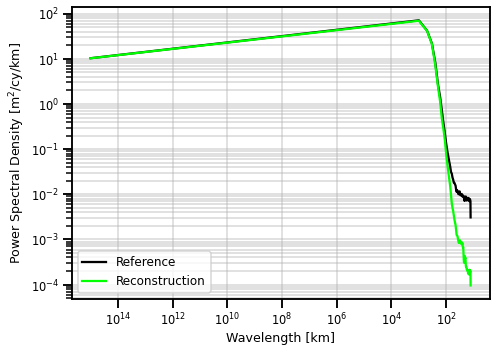

In [20]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

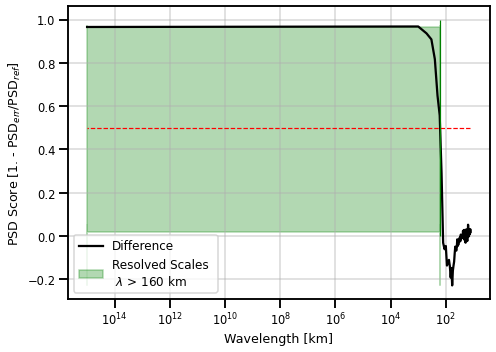

In [21]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [22]:
%%time
args.viz_dlon = 0.1
args.viz_dlat = 0.1

df_plot_grid = generate_plot_data(args)
df_plot = feature_transform(df_plot_grid.copy(), args, scaler=scaler)
data_plot = jnp.asarray(df_plot[["time", "longitude", "latitude"]].values)

CPU times: user 3.47 s, sys: 972 ms, total: 4.44 s
Wall time: 4.83 s


In [23]:
%%time

fn = partial(pred_step, model)

t0 = time.time()
df_plot["pred"] = batch_predict(
    data_plot, 
    fn, 
    args.eval_batch_size, 
    jnp.asarray
)
t1 = time.time() - t0

100%|██████████| 380/380 [00:42<00:00,  8.90it/s]

CPU times: user 3min 14s, sys: 4.84 s, total: 3min 18s
Wall time: 42.7 s


In [24]:
ds_oi_plot = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/miss

In [25]:
save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [26]:
ds_oi_plot

<xarray.Dataset>
Dimensions:    (latitude: 52, longitude: 51, time: 365)
Coordinates:
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 ... 967977 967978 967979
    vtime      (latitude, longitude, time) float64 31.0 32.0 ... 394.0 395.0
    pred       (latitude, longitude, time) float32 0.1894 0.191 ... 0.2156
    ssh        (latitude, longitude, time) float64 0.789 0.7906 ... 0.03923

In [27]:
# import hvplot.xarray


# ds_oi_plot.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

### Gradients

In [28]:
ds_oi_plot["ssh_grad"] = calculate_gradient(ds_oi_plot["ssh"], "longitude", "latitude")

In [29]:
# ds_oi_plot.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

### Laplacian

In [30]:
ds_oi_plot["ssh_lap"] = calculate_laplacian(ds_oi_plot["ssh"], "longitude", "latitude")

In [31]:
# ds_oi_plot.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")